In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2023-06-30 13:39:09.740047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 13:39:13.390199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/test_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_BaseNEncoder.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_Multi_dim_scale.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)
#molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv.gz", index_col=0).astype('int8')

In [3]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [4]:
g_train = nx.read_graphml("./graph/train_graph.gml")

In [5]:
g = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [6]:
#g = nx.create_empty_copy(g)
G = StellarGraph.from_networkx(g_merged,
                               node_features={'species': species_features_dummy,
                                              'molecule':molecule_features_dummy})

In [7]:
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 184990, Edges: 700916

 Node types:
  molecule: [148190]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [36800]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [350458]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [350458]
        Weights: all 1 (default)
        Features: none


In [8]:
model = tf.keras.models.load_model("./model/batch_128_layer_1024", compile=True)

In [9]:
test = df_agg[['structure_smiles_2D', 'organism_name']].to_numpy()

In [10]:
#test = test[['structure_smiles_2D', 'organism_name']].to_numpy()

In [11]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=[3,1],
                                head_node_types=["molecule", "species"]).flow(test, np.ones(len(test)).reshape(-1, 1))

In [12]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [13]:
result = predict(model, test_flow)

685/685 [==============================] - 12s 18ms/step


In [14]:
sum(result>0.9)/len(result)

0.5736640262971672

(array([ 1487.,   934.,  1003.,  1397.,  2019.,  3148.,  4808.,  7951.,
        14575., 50292.]),
 array([1.45928234e-05, 9.99981984e-02, 1.99981794e-01, 2.99965411e-01,
        3.99949014e-01, 4.99932617e-01, 5.99916220e-01, 6.99899793e-01,
        7.99883425e-01, 8.99866998e-01, 9.99850631e-01]),
 <BarContainer object of 10 artists>)

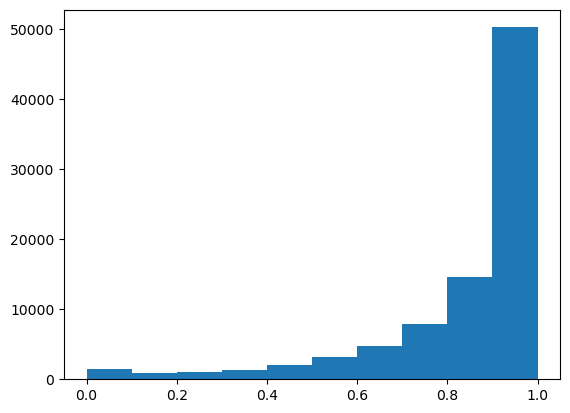

In [15]:
plt.hist(result)

In [16]:
sum(result>0.5)/len(result)

0.9219074577122378

In [17]:
res_single_run = model.predict(test_flow).flatten()

685/685 [==============================] - 13s 19ms/step


In [18]:
sum(res_single_run>0.5)/len(res_single_run)

0.8919236651676673

(array([ 2817.,  1577.,  1505.,  1615.,  1955.,  2546.,  3405.,  5244.,
        10070., 56880.]),
 array([6.66787673e-06, 1.00002907e-01, 1.99999154e-01, 2.99995393e-01,
        3.99991632e-01, 4.99987870e-01, 5.99984109e-01, 6.99980319e-01,
        7.99976587e-01, 8.99972796e-01, 9.99969065e-01]),
 <BarContainer object of 10 artists>)

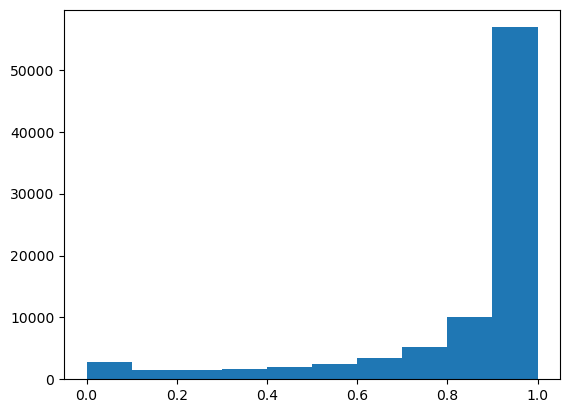

In [19]:
plt.hist(res_single_run)

In [20]:
try_test = np.array([['C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C12', 'Homo sapiens']])

In [21]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=256,
                                num_samples=[2,1],
                                head_node_types=["molecule", "species"]).flow(try_test, np.ones(len(try_test)).reshape(-1, 1))

In [44]:
test_2 = pd.DataFrame(data={'structure_smiles_2D': df_agg.structure_smiles_2D.sample(n=10000).to_numpy(),
                   'organism_name': df_agg.organism_name.sample(n=10000).to_numpy()}).to_numpy()

In [45]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=[3,1],
                                head_node_types=["molecule", "species"]).flow(test_2, np.ones(len(test_2)).reshape(-1, 1))

In [46]:
test_2_res = predict(model, test_flow)

79/79 [==============================] - 1s 18ms/step


(array([2283.,  757.,  656.,  679.,  667.,  711.,  838.,  890., 1024.,
        1495.]),
 array([3.73862849e-06, 9.99746919e-02, 1.99945644e-01, 2.99916595e-01,
        3.99887532e-01, 4.99858499e-01, 5.99829435e-01, 6.99800372e-01,
        7.99771369e-01, 8.99742305e-01, 9.99713242e-01]),
 <BarContainer object of 10 artists>)

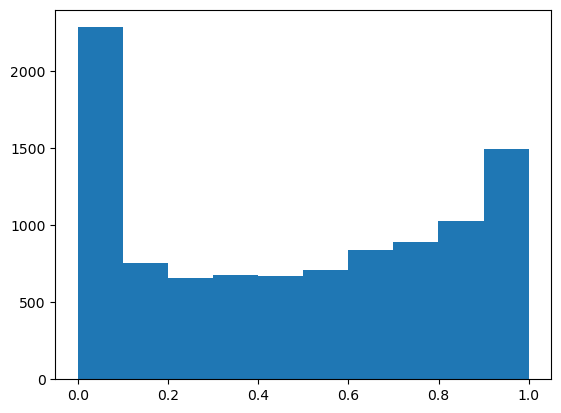

In [47]:
plt.hist(test_2_res)

In [48]:
test_2_res[test_2_res>0.9]

array([0.91605294, 0.9373144 , 0.99463254, ..., 0.9463377 , 0.94467485,
       0.92771405], dtype=float32)

In [52]:
final = pd.DataFrame(test_2[test_2_res>0.9])

In [53]:
final['prob'] = test_2_res[test_2_res>0.9]

In [54]:
final

,0,1,prob
0,CCCCCCCCCCO,Thuja plicata,0.916053
1,COCC(OC)C(OC)C(OC1OC(COC)C(OC2OC(C(=O)OC)C(OC3...,Cystophora congesta,0.937314
2,CC(C)=CCc1cc(CC2OC(=O)C(O)=C2c2ccc(O)cc2)ccc1O,Streptomyces,0.994633
3,COc1cc(C2OCC3(O)C(c4ccc(O)c(OC)c4)OCC23)ccc1O,Piper wightii,0.904672
4,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,Beilschmiedia erythrophloia,0.957535
...,...,...,...
1487,COc1cc(C=Cc2ccccc2)cc(OC)c1,Mikania banisteriae,0.912396
1488,CCCCCC=CCC=CCCCCCCCC(=O)OCC(O)CO,Persicaria minor,0.956033
1489,CCCCCCCCCCCCCCCCCCO,Galeopsis bifida,0.946338
1490,O=C(C=Cc1ccc(O)c(O)c1)OC1CC(O)(C(=O)O)CC(OC(=O...,Panax ginseng,0.944675


In [56]:
df = pd.read_csv("./data/230106_frozen_metadata.csv.gz")

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [67]:
df[df.organism_name.str.contains("var.")]

,structure_wikidata,structure_inchikey,structure_inchi,structure_smiles,structure_molecular_formula,structure_exact_mass,structure_xlogp,structure_smiles_2D,structure_cid,structure_nameIupac,...,organism_taxonomy_04class,organism_taxonomy_05order,organism_taxonomy_06family,organism_taxonomy_07tribe,organism_taxonomy_08genus,organism_taxonomy_09species,organism_taxonomy_10varietas,reference_wikidata,reference_doi,manual_validation
2140,http://www.wikidata.org/entity/Q903525,KSMVZQYAVGTKIV-UHFFFAOYSA-N,InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-9-10-11/h10H...,CCCCCCCCCC=O,C10H20O,156.151415,3.3260,CCCCCCCCCC=O,8175.0,decanal,...,Magnoliopsida,Rosales,Rosaceae,Amygdaleae,Prunus,Prunus persica,Prunus persica var. nucipersica,http://www.wikidata.org/entity/Q51476736,10.1016/J.FOODCHEM.2013.11.092,NaN
4441,http://www.wikidata.org/entity/Q43656,HVYWMOMLDIMFJA-DPAQBDIFSA-N,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,C27H46O,386.354866,7.3887,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,5997.0,"(3S,8S,9S,10R,13R,14S,17R)-10,13-dimethyl-17-[...",...,Florideophycidae,NaN,NaN,NaN,Callophyllis,Callophyllis variegata,NaN,http://www.wikidata.org/entity/Q104375056,10.1016/0305-1978(84)90026-7,NaN
6102,http://www.wikidata.org/entity/Q43656,HVYWMOMLDIMFJA-DPAQBDIFSA-N,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,C27H46O,386.354866,7.3887,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,5997.0,"(3S,8S,9S,10R,13R,14S,17R)-10,13-dimethyl-17-[...",...,Demospongiae,Dictyoceratida,Irciniidae,NaN,Ircinia,Ircinia variabilis,NaN,http://www.wikidata.org/entity/Q104375075,10.1016/0305-0491(84)90128-7,NaN
7726,http://www.wikidata.org/entity/Q2756479,SGNBVLSWZMBQTH-PODYLUTMSA-N,InChI=1S/C28H48O/c1-18(2)19(3)7-8-20(4)24-11-1...,CC(C)[C@H](C)CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3C...,C28H48O,400.370516,7.6347,CC(C)C(C)CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,173183.0,"(3S,8S,9S,10R,13R,14S,17R)-17-[(2R,5R)-5,6-dim...",...,Magnoliopsida,Sapindales,Rutaceae,NaN,Citrus,Citrus medica,Citrus medica var. sarcodactylis,http://www.wikidata.org/entity/Q104375041,10.1016/S0031-9422(00)83075-7,NaN
7727,http://www.wikidata.org/entity/Q2756479,SGNBVLSWZMBQTH-PODYLUTMSA-N,InChI=1S/C28H48O/c1-18(2)19(3)7-8-20(4)24-11-1...,CC(C)[C@H](C)CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3C...,C28H48O,400.370516,7.6347,CC(C)C(C)CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,173183.0,"(3S,8S,9S,10R,13R,14S,17R)-17-[(2R,5R)-5,6-dim...",...,Magnoliopsida,Sapindales,Rutaceae,NaN,Citrus,Citrus medica,Citrus medica var. sarcodactylis,http://www.wikidata.org/entity/Q104375041,10.1016/S0031-9422(00)83075-7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792030,http://www.wikidata.org/entity/Q424567,KZNIFHPLKGYRTM-UHFFFAOYSA-N,InChI=1S/C15H10O5/c16-9-3-1-8(2-4-9)13-7-12(19...,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,C15H10O5,270.052823,2.5768,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,5280443.0,"5,7-dihydroxy-2-(4-hydroxyphenyl)chromen-4-one",...,Magnoliopsida,Brassicales,Brassicaceae,Brassiceae,Brassica,Brassica oleracea,Brassica oleracea var. alboglabra,http://www.wikidata.org/entity/Q104666735,10.1002/(SICI)1097-0010(200004)80:5<561::AID-J...,NaN
792035,http://www.wikidata.org/entity/Q415011,IQPNAANSBPBGFQ-UHFFFAOYSA-N,InChI=1S/C15H10O6/c16-8-4-11(19)15-12(20)6-13(...,O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,C15H10O6,286.047738,2.2824,O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,5280445.0,"2-(3,4-dihydroxyphenyl)-5,7-dihydroxychromen-4...",...,Magnoliopsida,Brassicales,Brassicaceae,Brassiceae,Brassica,Brassica oleracea,Brassica oleracea var. alboglabra,http://www.wikidata.org/entity/Q104666735,10.1002/(SICI)1097-0010(200004)80:5<561::AID-J...,NaN
792040,http://www.wikidata.org/entity/Q393336,IYRMWMYZSQPJKC-UHFFFAOYSA-N,InChI=1S/C15H10O6/c16-8-3-1-7(2-4-8)15-14(20)1...,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,C15H10O6,286.047738,2.2824,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,5280863.0,"3,5,7